In [1]:
import numpy as np
import pandas as pd
import os
import io
import seaborn as sns
import requests
import json

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy
import scipy.stats as stats
import scipy.optimize as opt
#import statsmodels.api as sm

from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated, Mixture
import theano.tensor as tt 
from pymc3.distributions.distribution import Continuous, draw_values, generate_samples

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', 500)
%matplotlib inline 

In [2]:
#Get NHL Data for Last Season
r = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?stats=gameLog&season=20172018&team=12')
data = r.json()

In [3]:
gameType = []
away = []
home = []
away_score = []
home_score = []
venue = []
gameDate = []
gameState = []
gameid = []

In [4]:
for date in data['dates']:
    for game in date['games']:
        gameType.append(game['gameType'])
        away.append(game['teams']['away']['team']['name'])
        home.append(game['teams']['home']['team']['name'])
        away_score.append(game['teams']['away']['score'])
        home_score.append(game['teams']['home']['score'])
        venue.append(game['venue']['name'])
        gameDate.append(str(date['date']))
        gameState.append(game['status']['statusCode'])
        gameid.append(game['gamePk'])
    print("Done with " + str(date['date']))

Done with 2017-09-16
Done with 2017-09-17
Done with 2017-09-18
Done with 2017-09-19
Done with 2017-09-20
Done with 2017-09-21
Done with 2017-09-22
Done with 2017-09-23
Done with 2017-09-24
Done with 2017-09-25
Done with 2017-09-26
Done with 2017-09-27
Done with 2017-09-28
Done with 2017-09-29
Done with 2017-09-30
Done with 2017-10-01
Done with 2017-10-04
Done with 2017-10-05
Done with 2017-10-06
Done with 2017-10-07
Done with 2017-10-08
Done with 2017-10-09
Done with 2017-10-10
Done with 2017-10-11
Done with 2017-10-12
Done with 2017-10-13
Done with 2017-10-14
Done with 2017-10-15
Done with 2017-10-16
Done with 2017-10-17
Done with 2017-10-18
Done with 2017-10-19
Done with 2017-10-20
Done with 2017-10-21
Done with 2017-10-22
Done with 2017-10-23
Done with 2017-10-24
Done with 2017-10-25
Done with 2017-10-26
Done with 2017-10-27
Done with 2017-10-28
Done with 2017-10-29
Done with 2017-10-30
Done with 2017-10-31
Done with 2017-11-01
Done with 2017-11-02
Done with 2017-11-03
Done with 201

In [5]:
df = pd.DataFrame({'GameType': gameType, 'Away': away, 'Home': home, 'Away_Score': away_score, 'Home_Score': home_score,
                   'Venue': venue, 'GameDate': gameDate, 'GameState': gameState, 'GameID': gameid})

In [6]:
def get_canes_goals(row):
    if (row['Away'] == 'Carolina Hurricanes') and (row['Home'] != 'Carolina Hurricanes'):
        return row['Away_Score']
    elif (row['Away'] != 'Carolina Hurricanes') and (row['Home'] == 'Carolina Hurricanes'):
        return row['Home_Score']
    else:
        return "WTF!"
    
def get_oppo_goals(row):
    if (row['Away'] == 'Carolina Hurricanes') and (row['Home'] != 'Carolina Hurricanes'):
        return row['Home_Score']
    elif (row['Away'] != 'Carolina Hurricanes') and (row['Home'] == 'Carolina Hurricanes'):
        return row['Away_Score']
    else:
        return "WTF!"
    
#Overtime? 
def get_overtime(row):
    r = requests.get('https://statsapi.web.nhl.com/api/v1/game/'+ str(row['GameID']) + '/linescore')
    gamedata = r.json()
    overtime = False
    for period in gamedata['periods']:
        if period['periodType'] == 'OVERTIME':
            overtime = True
    return overtime 

In [7]:
canes_df = df[(df['Away'] == 'Carolina Hurricanes') | (df['Home'] == 'Carolina Hurricanes')].reset_index()
canes_df['Canes_Goals'] = canes_df.apply(lambda row: get_canes_goals(row), axis=1)
canes_df['Oppo_Goals'] = canes_df.apply(lambda row: get_oppo_goals(row), axis=1)
canes_df['Goal_Diff'] = canes_df['Canes_Goals'] - canes_df['Oppo_Goals']
canes_df['Overtime?'] = canes_df.apply(lambda row: get_overtime(row), axis=1)
canes_df['Adj_Goal_Diff'] = canes_df.apply(lambda row: row['Goal_Diff'] if row['Overtime?'] is False else 0, axis=1)
canes_df = canes_df[canes_df['GameType'] != 'PR']

In [46]:
#Get Data for the 2018-2019 Pre-Season
r = requests.get('https://statsapi.web.nhl.com/api/v1/schedule?stats=gameLog&season=20182019&team=12')
data = r.json()

In [47]:
gameType = []
away = []
home = []
away_score = []
home_score = []
venue = []
gameDate = []
gameState = []
gameid = [] 

In [48]:
for date in data['dates']:
    for game in date['games']:
        gameType.append(game['gameType'])
        away.append(game['teams']['away']['team']['name'])
        home.append(game['teams']['home']['team']['name'])
        away_score.append(game['teams']['away']['score'])
        home_score.append(game['teams']['home']['score'])
        venue.append(game['venue']['name'])
        gameDate.append(game['gameDate'])
        gameState.append(game['status']['statusCode'])
        gameid.append(game['gamePk'])
    print("Done with " + str(date['date']))

Done with 2018-09-15
Done with 2018-09-16
Done with 2018-09-17
Done with 2018-09-18
Done with 2018-09-19
Done with 2018-09-20
Done with 2018-09-21
Done with 2018-09-22
Done with 2018-09-23
Done with 2018-09-24
Done with 2018-09-25
Done with 2018-09-26
Done with 2018-09-27
Done with 2018-09-28
Done with 2018-09-29
Done with 2018-09-30
Done with 2018-10-01
Done with 2018-10-03
Done with 2018-10-04
Done with 2018-10-05
Done with 2018-10-06
Done with 2018-10-07
Done with 2018-10-08
Done with 2018-10-09
Done with 2018-10-10
Done with 2018-10-11
Done with 2018-10-13
Done with 2018-10-14
Done with 2018-10-15
Done with 2018-10-16
Done with 2018-10-17
Done with 2018-10-18
Done with 2018-10-19
Done with 2018-10-20
Done with 2018-10-21
Done with 2018-10-22
Done with 2018-10-23
Done with 2018-10-24
Done with 2018-10-25
Done with 2018-10-26
Done with 2018-10-27
Done with 2018-10-28
Done with 2018-10-29
Done with 2018-10-30
Done with 2018-10-31
Done with 2018-11-01
Done with 2018-11-02
Done with 201

In [49]:
df18 = pd.DataFrame({'GameType': gameType, 'Away': away, 'Home': home, 'Away_Score': away_score, 'Home_Score': home_score,
                   'Venue': venue, 'GameDate': gameDate, 'GameState': gameState, 'GameID': gameid})
canes_df2 = df18[(df18['Away'] == 'Carolina Hurricanes') | (df18['Home'] == 'Carolina Hurricanes')].reset_index()
canes_df2 = canes_df2[(canes_df2['GameState'] == '6') | (canes_df2['GameState'] == '7')]
canes_df2['Canes_Goals'] = canes_df2.apply(lambda row: get_canes_goals(row), axis=1)
canes_df2['Oppo_Goals'] = canes_df2.apply(lambda row: get_oppo_goals(row), axis=1)
canes_df2['Goal_Diff'] = canes_df2['Canes_Goals'] - canes_df2['Oppo_Goals']
canes_df2['Overtime?'] = canes_df2.apply(lambda row: get_overtime(row), axis=1)
#New Adjusted Goal Diff
canes_df2['Adj_Goal_Diff'] = canes_df2.apply(lambda row: row['Goal_Diff'] if row['Overtime?'] is False else 0, axis=1)
canes_df2 = canes_df2[canes_df2['GameType'] != 'PR']
canes_df2 = canes_df2.reset_index()

In [50]:
canes_df2

,level_0,index,GameType,Away,Home,Away_Score,Home_Score,Venue,GameDate,GameState,GameID,Canes_Goals,Oppo_Goals,Goal_Diff,Overtime?,Adj_Goal_Diff
0,6,116,R,New York Islanders,Carolina Hurricanes,2,1,PNC Arena,2018-10-04T23:00:00Z,7,2018020008,1,2,-1,True,0
1,7,124,R,Carolina Hurricanes,Columbus Blue Jackets,3,1,Nationwide Arena,2018-10-05T23:00:00Z,7,2018020015,3,1,2,False,2
2,8,138,R,New York Rangers,Carolina Hurricanes,5,8,PNC Arena,2018-10-07T21:00:00Z,7,2018020029,8,5,3,False,3
3,9,146,R,Vancouver Canucks,Carolina Hurricanes,3,5,PNC Arena,2018-10-09T23:00:00Z,7,2018020037,5,3,2,False,2
4,10,170,R,Carolina Hurricanes,Minnesota Wild,5,4,Xcel Energy Center,2018-10-13T22:00:00Z,7,2018020060,5,4,1,True,0
5,11,182,R,Carolina Hurricanes,Winnipeg Jets,1,3,Bell MTS Place,2018-10-14T23:00:00Z,7,2018020073,1,3,-2,False,-2
6,12,191,R,Carolina Hurricanes,Tampa Bay Lightning,2,4,Amalie Arena,2018-10-16T23:30:00Z,7,2018020082,2,4,-2,False,-2
7,13,212,R,Colorado Avalanche,Carolina Hurricanes,3,1,PNC Arena,2018-10-20T17:00:00Z,7,2018020103,1,3,-2,False,-2
8,14,228,R,Carolina Hurricanes,Detroit Red Wings,3,1,Little Caesars Arena,2018-10-22T23:30:00Z,7,2018020119,3,1,2,False,2
9,15,255,R,San Jose Sharks,Carolina Hurricanes,3,4,PNC Arena,2018-10-26T23:30:00Z,7,2018020146,4,3,1,True,0


In [11]:
with pm.Model() as model:
    
    #Pooled Parameters
    mu_normal = pm.Uniform('mu_normal', lower=-10.0, upper=10.0)
    sd_normal = pm.Uniform('sd_normal', lower=0.5, upper=6)
    #nu_t = pm.Uniform('nu_normal', lower=1, upper=100)
    
    likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=canes_df['Adj_Goal_Diff'].values)
    #y_est = pm.Normal('y_est', mu=mu_normal, sd=sd_normal)
    
    trace = pm.sample(10000, cores=-1, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 12500/12500 [00:09<00:00, 1370.40it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e1d08a438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6e1cb0f6d8>]], dtype=object)

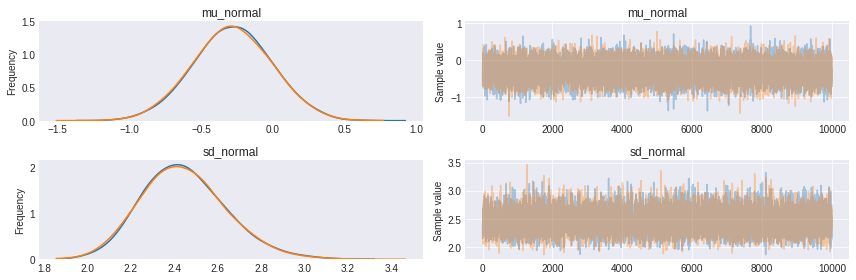

In [12]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e1c239630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f6e1c1a1c50>], dtype=object)

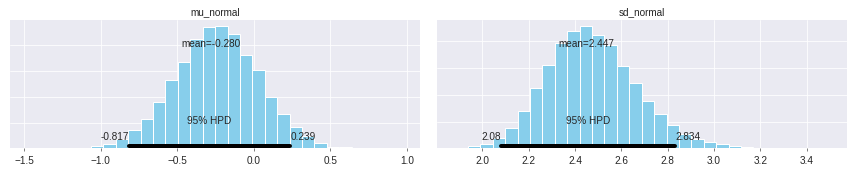

In [13]:
pm.plot_posterior(trace)

In [14]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

In [23]:
def prob_persona_faster(persona, personb):
    return np.float(sum(np.array(persona) - np.array(personb) > 0))/len(personb)

In [ ]:
probabilities

In [27]:
#probabilities = []
for i in range(11, 21):
    observed = canes_df2[0:i+1]['Adj_Goal_Diff'].values
    with pm.Model() as model:
    
        #Pooled Parameters
        mu_normal = from_posterior('mu_normal', trace['mu_normal'])
        sd_normal = from_posterior('sd_normal', trace['sd_normal'])

        likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=observed)
        #y_est = pm.Normal('y_est', mu=mu_normal, sd=sd_normal)

        #difference = pm.Deterministic('difference', y_est-trace['y_est'])

        trace2 = pm.sample(10000, cores=-1, tune=2500)
        #preds = pm.sample_ppc(trace)
    
    probabilities.append(prob_persona_faster(trace2.get_values('mu_normal'), trace.get_values('mu_normal')))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 12500/12500 [00:14<00:00, 887.33it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 12500/12500 [00:13<00:00, 944.44it/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 12500/12500 [00:13<00:00, 924.90it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71507219842, but should be close to 0.8. Try to increase the number of tuning steps.
The

In [28]:
len(probabilities)

21

In [29]:
def get_opponent(row):
    print(row['Away'])
    if row['Away'] == 'Carolina Hurricanes':
        return row['Home']
    else:
        return row['Away']

In [30]:
canes_df2['Opponent'] = canes_df2.apply(lambda row: get_opponent(row), axis=1)

New York Islanders
Carolina Hurricanes
New York Rangers
Vancouver Canucks
Carolina Hurricanes
Carolina Hurricanes
Carolina Hurricanes
Colorado Avalanche
Carolina Hurricanes
San Jose Sharks
New York Islanders
Boston Bruins
Carolina Hurricanes
Carolina Hurricanes
Carolina Hurricanes
Carolina Hurricanes
Detroit Red Wings
Chicago Blackhawks
Columbus Blue Jackets
New Jersey Devils
Toronto Maple Leafs


In [31]:
canes_df2['Probabilities'] = probabilities

In [ ]:
# sns.lineplot(x=canes_df2.index, y=probabilities)

In [33]:
canes_df2['Opponent2'] =  pd.to_datetime(canes_df2['GameDate']).dt.strftime("%b %d")+ " \n " + canes_df2['Opponent']

In [34]:
canes_df2['Opponent3'] = pd.to_datetime(canes_df2['GameDate']).dt.strftime("%b %d")+ " \n " + canes_df2['Opponent'].str.split(" ").str.join(" \n ")

In [35]:
canes_df2['Opponent'].str

In [36]:
canes_df2

,level_0,index,GameType,Away,Home,Away_Score,Home_Score,Venue,GameDate,GameState,GameID,Canes_Goals,Oppo_Goals,Goal_Diff,Overtime?,Adj_Goal_Diff,Opponent,Probabilities,Opponent2,Opponent3
0,6,116,R,New York Islanders,Carolina Hurricanes,2,1,PNC Arena,2018-10-04T23:00:00Z,7,2018020008,1,2,-1,True,0,New York Islanders,0.50350,Oct 04 \n New York Islanders,Oct 04 \n New \n York \n Islanders
1,7,124,R,Carolina Hurricanes,Columbus Blue Jackets,3,1,Nationwide Arena,2018-10-05T23:00:00Z,7,2018020015,3,1,2,False,2,Columbus Blue Jackets,0.53435,Oct 05 \n Columbus Blue Jackets,Oct 05 \n Columbus \n Blue \n Jackets
2,8,138,R,New York Rangers,Carolina Hurricanes,5,8,PNC Arena,2018-10-07T21:00:00Z,7,2018020029,8,5,3,False,3,New York Rangers,0.57075,Oct 07 \n New York Rangers,Oct 07 \n New \n York \n Rangers
3,9,146,R,Vancouver Canucks,Carolina Hurricanes,3,5,PNC Arena,2018-10-09T23:00:00Z,7,2018020037,5,3,2,False,2,Vancouver Canucks,0.59640,Oct 09 \n Vancouver Canucks,Oct 09 \n Vancouver \n Canucks
4,10,170,R,Carolina Hurricanes,Minnesota Wild,5,4,Xcel Energy Center,2018-10-13T22:00:00Z,7,2018020060,5,4,1,True,0,Minnesota Wild,0.60230,Oct 13 \n Minnesota Wild,Oct 13 \n Minnesota \n Wild
5,11,182,R,Carolina Hurricanes,Winnipeg Jets,1,3,Bell MTS Place,2018-10-14T23:00:00Z,7,2018020073,1,3,-2,False,-2,Winnipeg Jets,0.59010,Oct 14 \n Winnipeg Jets,Oct 14 \n Winnipeg \n Jets
6,12,191,R,Carolina Hurricanes,Tampa Bay Lightning,2,4,Amalie Arena,2018-10-16T23:30:00Z,7,2018020082,2,4,-2,False,-2,Tampa Bay Lightning,0.56370,Oct 16 \n Tampa Bay Lightning,Oct 16 \n Tampa \n Bay \n Lightning
7,13,212,R,Colorado Avalanche,Carolina Hurricanes,3,1,PNC Arena,2018-10-20T17:00:00Z,7,2018020103,1,3,-2,False,-2,Colorado Avalanche,0.54410,Oct 20 \n Colorado Avalanche,Oct 20 \n Colorado \n Avalanche
8,14,228,R,Carolina Hurricanes,Detroit Red Wings,3,1,Little Caesars Arena,2018-10-22T23:30:00Z,7,2018020119,3,1,2,False,2,Detroit Red Wings,0.56780,Oct 22 \n Detroit Red Wings,Oct 22 \n Detroit \n Red \n Wings
9,15,255,R,San Jose Sharks,Carolina Hurricanes,3,4,PNC Arena,2018-10-26T23:30:00Z,7,2018020146,4,3,1,True,0,San Jose Sharks,0.57075,Oct 26 \n San Jose Sharks,Oct 26 \n San \n Jose \n Sharks


[ 0.      0.5035]
[ 1.       0.53435]
[ 2.       0.57075]
[ 3.      0.5964]
[ 4.      0.6023]
[ 5.      0.5901]
[ 6.      0.5637]
[ 7.      0.5441]
[ 8.      0.5678]
[ 9.       0.57075]
[ 10.       0.5604]
[ 11.       0.5578]
[ 12.      0.562]
[ 13.        0.52585]
[ 14.       0.4938]
[ 15.       0.5075]
[ 16.        0.51395]
[ 17.       0.5101]
[ 18.        0.47815]
[ 19.        0.49325]
[ 20.        0.53285]


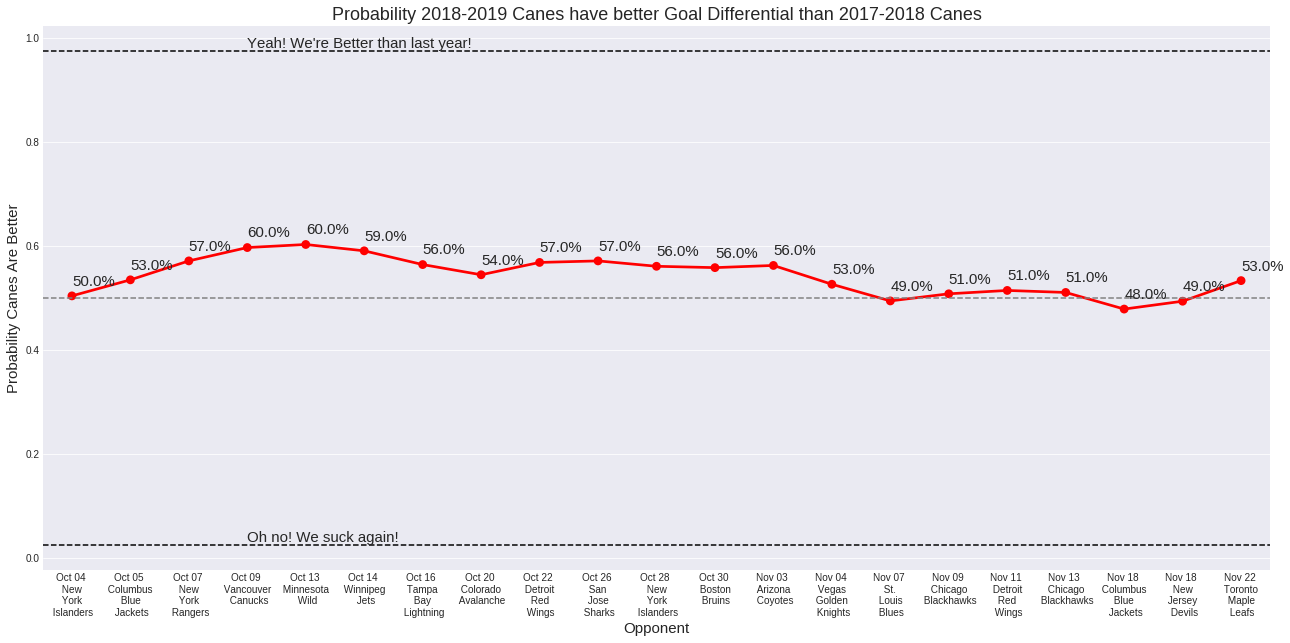

In [38]:
fig, ax = plt.subplots(figsize=(22, 10))
ax.set_title('Probability 2018-2019 Canes have better Goal Differential than 2017-2018 Canes', fontsize=18)
p1 = sns.pointplot(x=canes_df2['Opponent3'], y=canes_df2['Probabilities'], color='red')
plt.axhline(.975, color='black', ls='--', label= "Yeah! We're Better than Last Year!")
plt.axhline(.025, color='black', ls='--', label= "Nope We Suck")
plt.axhline(.50, color='grey', ls='--')
p1.set_ylabel('Probability Canes Are Better', fontsize=15)
p1.set_xlabel('Opponent', fontsize=15)
for c in ax.collections:
    for of in c.get_offsets():
        print(of)
        of2 = [of[0], of[1]+0.02]
        ax.annotate('%r' % round(of[1]*100, 0) + "%", of2, size=15)
ax.annotate("Yeah! We're Better than last year!", [3, .98], size=15)
ax.annotate("Oh no! We suck again!", [3, .03], size=15)
plt.show()

In [ ]:
canes_df2['Probabilities'] = probabilities

In [ ]:
canes_df3 = pd.read_csv("Desktop/canes.csv")

In [45]:
canes_df2.to_csv("canes.csv")